In [1]:
#Process docking results and correlate RMSD with chemical features of molecules
#11/13/23 added an update- Spearman correlation
#Hoping to obtain a file of protein features/P-L complex features, which can also be correlated with RMSD
#12/11/23 higher throughput
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import copy

In [2]:
pdbpath = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"

pdb_list = "/Users/dsharon/Documents/MIT/6.8701/Project/Data/From_Hannes/HarmonicFlow_complex_names.npy"


#From Hannes
with open(pdb_list, 'rb') as f:
    complex_names = np.load(pdb_list)

In [3]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [4]:
##########
#Check consensus distances
#Input:
#(a) conf_for_c conformers' coordinates
#(b) atom_pair_dict pairs of atoms for distance analysis across conformers
#(c) analysis_label string describing analysis
#(d) sd_cutoff_for_lower standard deviation ceiling
#Output
#(a) count_lower_sd count of SDs below the ceiling
#(b) max_sd maximum SD
#(c) sd_list list of SDs
##########
def consensus_check(conf_for_c,
                    atom_pair_dict,
                    analysis_label,
                    sd_cutoff_for_lower):

    #holds all pairwise dists
    pair_dists = []
    
    #pairwise dists for each pair
    pair_dist_dict = {}

    #keys atom pairs
    #values distance list- one distance/conformer
    for a1add in atom_pair_dict.keys():
        for a1addpair in atom_pair_dict[a1add]:
            pair_dist_dict[tuple(sorted([a1add, a1addpair]))] = []

    #print(away_1_dist_dict)

    #Iterate over conformers
    for conf in conf_for_c:
        #for each conformer refresh so do not duplicate e.g. (1,2) and then (2,1)
        already_checked = []
        #print("new conf")

        #Each heavy atom
        for away1 in atom_pair_dict.keys():

            #Each heavy atom partner of interest
            for away1pair in atom_pair_dict[away1]:

                #Make sure not already found
                if sorted([away1, away1pair]) not in already_checked:
                    already_checked.append([away1, away1pair])

                    #Coordinate find, distance find
                    #print(f"{away1} {away1pair}")
                    away1coords = conf[away1]
                    away2coords = conf[away1pair]
                    #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
                    dist = np.linalg.norm(away1coords - away2coords)

                    #Add to list and dictionary
                    pair_dists.append(dist)
                    #print(away_1_dist_dict[tuple(sorted([away1, away1pair]))])
                    key_update = tuple(sorted([away1, away1pair]))
                    pair_dist_dict[key_update].append(dist)

    avg_list = []
    sd_list = []
    for paircalc in pair_dist_dict.keys():
        dist_analyze = pair_dist_dict[paircalc]
        avg_list.append(np.average(dist_analyze))
        sd_list.append(np.std(dist_analyze, ddof = 1))
        
    #10:16 find max SD to help pick cutoff
    max_sd = max(sd_list)

    #SD histogram
    '''
    plt.hist(sd_list)
    plt.title(f"SD Histogram for {analysis_label}")
    plt.xlabel("Distance SD Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    '''
    #SD histogram
    #Low values only
    sd_list_lower = [s for s in sd_list if s < sd_cutoff_for_lower]
    count_lower_sd = len(sd_list_lower)
    #print(sd_list_lower)
    lower_bins = np.linspace(0, sd_cutoff_for_lower, 21)
    #print("lower bins")
    #print(lower_bins)
    
    '''
    plt.hist(sd_list_lower, bins = lower_bins)
    plt.title(f"SD Histogram Low Values for {analysis_label}")
    plt.xlabel("Distance SD Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    
    #Average histogram
    plt.hist(avg_list)
    plt.title(f"Average Histogram for {analysis_label}")
    plt.xlabel("Distance Average Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    
    #Scatterplot
    plt.scatter(avg_list, sd_list)
    plt.title(f"Scatterplot for {analysis_label}")
    plt.xlabel("Distance Average Across Conformers (Å)")
    plt.ylabel("Distance SD Across Conformers (Å)")
    plt.show()
    plt.cla()
    plt.clf()
    '''
    
    return count_lower_sd, max_sd, sd_list

In [5]:
##########
#Launch conformer consensus distance analysis
#Input:
#(a) l_analyze ligand analyzing
#(b) cutoff_sd cutoff for sd further away
#Output:
#(a) below_2_away count of distances (2 bonds away) below cutoff
#(b) below_further_away count of distances (further than 2 bonds away) below cutoff
#(c) a2maxsd max sd of 2 away distances
#(d) afurthersdlist list of all distances' over 2 bonds away. sds across conformers
#(e) boolean for whether there was an error
##########
def run_consensus_analysis(l_analyze, cutoff_sd):
    
    ##########
    #(a) conformer generation
    ##########
    num_conf = 10
    #Copied from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
    #Thank you Jeremy!
    #copied from ps down to conformers.append
    ps = AllChem.ETKDGv2()
    ids = rdDistGeom.EmbedMultipleConfs(l_analyze, num_conf, ps)
    
    #To protect against bad conformer error
    #Ref https://www.w3schools.com/python/python_try_except.asp
    try:
        if -1 in ids:
            print('rdkit coords could not be generated without using random coords. using random coords now.')
            ps.useRandomCoords = True
            ids = rdDistGeom.EmbedMultipleConfs(l_analyze, num_conf, ps)
            AllChem.MMFFOptimizeMoleculeConfs(l_analyze)
        else:
            #print("ids")
            #print(ids)
            AllChem.MMFFOptimizeMoleculeConfs(l_analyze)
        conformers = []
        for i in range(num_conf):
            conformers.append(l_analyze.GetConformer(i).GetPositions())
        #print(conformers[0])
        #print(len(conformers))

        ##########
        #(b) connectivity info parsing
        ##########
        #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
        heavy_atom_list = []
        heavy_atom_bonds = []

        #Record all heavy atoms
        for a in lig.GetAtoms():
            if a.GetAtomicNum() > 1:
                #print(f"found atom {a.GetSymbol()}")
                heavy_atom_list.append(a.GetIdx())
            #else:
                #print("found H")

        #Find each bond, record
        for b in lig.GetBonds():
            at1 = b.GetBeginAtomIdx()
            at2 = b.GetEndAtomIdx()
            at1_an = lig.GetAtomWithIdx(at1).GetAtomicNum()
            at2_an = lig.GetAtomWithIdx(at2).GetAtomicNum()
            if at1_an == 1 or at2_an == 1:
                continue
            else:
                #print("heavy atom bond")
                #print(f"{at1} element {at1_an}")
                #print(f"{at2} element {at2_an}")
                #print("----")
                heavy_atom_bonds.append([at1, at2])
            #print([x.GetAtomicNum() for x in at.GetNeighbors()])

        ##########
        #(c) collect 1 and 2 and more away info
        ##########

        #keys- atoms, values- neighbors 1 and 2 away
        atom_neighbor_dict_12_away = {}
        atom_neighbor_dict_1_away = {}
        atom_neighbor_dict_2_away = {}
        atom_neighbor_dict_further_away = {}

        #Initialize and 1st shell neighbors
        for a in heavy_atom_list:
            atom_neighbor_dict_1_away[a] = []

            #Add all 1 away
            for b in heavy_atom_bonds:
                #print(b)
                if b[0] == a:
                    atom_neighbor_dict_1_away[a].append(b[1])
                if b[1] == a:
                    atom_neighbor_dict_1_away[a].append(b[0])
        #print("1 away")
        #print(atom_neighbor_dict_1_away)

        #2 away neighbors
        for a2 in heavy_atom_list:
            atom_neighbor_dict_2_away[a2] = []

            #Now add in the neighbor's neighbors
            #All 1 away from the neighbor
            #Filter for a2 though
            for b2 in heavy_atom_bonds:
                #print(b2)
                if b2[0] == a2:
                    neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[1]] if i is not a2]
                    atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2
                if b2[1] == a2:
                    neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[0]] if i is not a2]
                    atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2

        #print("2 away")
        #print(atom_neighbor_dict_2_away)

        #Combine 1 and 2 away
        for a12 in heavy_atom_list:
            atom_neighbor_dict_12_away[a12] = list(set(atom_neighbor_dict_1_away[a12] + atom_neighbor_dict_2_away[a12]))

        #print("1 and 2 away")
        #print(atom_neighbor_dict_12_away)

        #More than 2 away
        for afurther in heavy_atom_list:
            further_list = []

            #Add to further list if not atom itself or a 1/2 away neighbor
            for a_add in heavy_atom_list:
                if ((a_add != afurther) and (a_add not in atom_neighbor_dict_12_away[afurther])):
                    further_list.append(a_add)
            atom_neighbor_dict_further_away[afurther] = further_list
        #print("further")
        #print(atom_neighbor_dict_further_away)

        below_1_away, a1maxsd, a1sdlist = consensus_check(conformers,
                                        atom_neighbor_dict_1_away, 
                                        "1_away",
                                        cutoff_sd)

        below_2_away, a2maxsd, a2sdlist = consensus_check(conformers,
                                        atom_neighbor_dict_2_away, 
                                        "2_away",
                                        cutoff_sd)

        below_12_away, a12maxsd, a12sdlist = consensus_check(conformers,
                                        atom_neighbor_dict_12_away, 
                                        "12_away",
                                        cutoff_sd)

        below_further_away, afurthermaxsd, afurthersdlist = consensus_check(conformers,
                                            atom_neighbor_dict_further_away, 
                                            "further",
                                            cutoff_sd)

        return below_2_away, below_further_away, a2maxsd, afurthersdlist, False
    
    except:
        print("Error")
        return None, None, None, None, True

In [7]:
#Pull sdf/mol2 and then smiles
count_of_d_2_below_cutoff = [] #how many 2 away distances have sd below cutoff
count_of_d_further_below_cutoff = [] #how many 3+ away distances have sd below cutoff
sd_2a_max_list = [] #for each complex the max 2 away sd to help with cutoff selection
all_further_sd_list = []  #each entry is a. list of the further sds for one pdb, for ease of multiple cutoff analysis
sd_cutoff = 0.10

#Hold pdb errors
pdb_error_list = []

#pdbs which gave errors
#Ref for errors https://github.com/rdkit/rdkit/issues/1433
'''
pdbs_not_using = ["6oie", 
                  "6mja", 
                  "6s07", 
                  "5zjz", 
                  "6mjq", 
                  "6qtr", 
                  "6mji", 
                  "6qto", 
                  "6q36", 
                  "5zk9", 
                  "6d07", 
                  "6hld", 
                  "6hmy", 
                  "6sen",
                  "5zjy",
                  "6mjj",
                  "6mj4",
                  "6seo",
                  "5zml",
                  "6miv",
                  "6hlb",
                  "5zk5",
                  "6miy"]
'''

for pi, pdb_name in enumerate(complex_names):
    
    print(f"On {pi} {pdb_name}")
    #if pdb_name not in pdbs_not_using:


    #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
    for file in os.listdir(os.path.join(pdbpath, pdb_name)):
        if file.endswith(".sdf") and 'rdkit' not in file:
            lig = read_molecule(os.path.join(pdbpath, pdb_name, file), remove_hs=False, sanitize=True)
            if lig is None and os.path.exists(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                lig = read_molecule(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)

    count_d_2, count_d_over_2, sd2awaymax, sd_over_2_list, had_error = run_consensus_analysis(lig, sd_cutoff)
    if not had_error:
        count_of_d_2_below_cutoff.append(count_d_2)
        count_of_d_further_below_cutoff.append(count_d_over_2)
        sd_2a_max_list.append(sd2awaymax)
        all_further_sd_list.append(sd_over_2_list)
    else:
        pdb_error_list.append(pdb_name)

On 0 6jt3
On 1 6jbb
On 2 6ufo
On 3 6os6
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 4 6jbe


[12:44:15] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


On 5 6qra
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:44:16] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


On 6 6qsz
On 7 6jam
On 8 6a87
On 9 6oie
Error
On 10 6n4b
On 11 6dyz
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:44:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 20 21


On 12 6hhh
On 13 6i5p
On 14 6e6v
On 15 6o9c
On 16 6c85
On 17 6e13
On 18 6cjj
On 19 6nri
On 20 6mja
Error
On 21 6qr7
Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:45:24] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 28


On 22 6o0h
On 23 6qmt
On 24 6ibz
On 25 6d3y
On 26 6qr0
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:46:13] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


On 27 6s9w
On 28 6p8x
On 29 6s07
Error
On 30 6fe5
On 31 6oxp
On 32 5zlf
On 33 6n8x
On 34 6qtw
On 35 6mhd
On 36 6jut
Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:46:56] Can't kekulize mol.  Unkekulized atoms: 2 3 5 19 20 21 22 23 25


On 37 6uhu
Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:46:58] Explicit valence for atom # 0 C, 5, is greater than permitted


On 38 6i8m
On 39 6ckl
On 40 6e6j
Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:47:00] Can't kekulize mol.  Unkekulized atoms: 1 2 6 29 32


On 41 5zjz
Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:47:02] Can't kekulize mol.  Unkekulized atoms: 120 121 122 123 124 125 126 127 128


Error
On 42 6qts
On 43 6h12
On 44 6pno
On 45 6mo2
Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:47:42] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32


On 46 6oxv
On 47 5zxk
On 48 6cjs
On 49 6mjq
Error
On 50 6mo0
On 51 6ahs
On 52 6gj7
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:47:56] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 14 15 16 17 33


On 53 6cyh
On 54 6gzy
On 55 6oxy
On 56 6oxr
On 57 6qlr
On 58 6i8t
On 59 6qtr
Error
On 60 6i62
On 61 6qqu
Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 62 6rnu


[12:48:27] Can't kekulize mol.  Unkekulized atoms: 0 1 8 9 10 11 12 13 14


On 63 6pyb
On 64 6oiq
On 65 6ggf
On 66 6qrd
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:48:30] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13


On 67 6npi
On 68 6rr0
On 69 6mji
Error
On 70 6qqw
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:48:59] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


On 71 6k2n
On 72 6qto
Error
On 73 6mo8
On 74 6hzd
On 75 6efk
On 76 6oin
On 77 6jsf
On 78 6k04
On 79 6oxw
On 80 6pya
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:49:36] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 18


On 81 6qqt
Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:49:36] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11


On 82 6ooz
On 83 6ny0
On 84 6izq
On 85 6oir
On 86 6ic0
On 87 6a73
On 88 6j06
On 89 6qr4
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:49:42] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 23


On 90 6g9f
On 91 6os5
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:49:44] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


On 92 6q36
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:49:44] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 22


Error
On 93 6qr9
Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:50:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 28


On 94 5zcu
On 95 6e3z
On 96 6jid
On 97 6fff
On 98 6te6
On 99 6o5u
On 100 6gge
On 101 6uvv
On 102 5zk9
Error
On 103 6pnn
On 104 6d07
Error
On 105 6oy0
On 106 6e3m
On 107 6cyg
On 108 6i41
On 109 6qmr
On 110 6hbn
On 111 6qlp
On 112 6h9v
On 113 6qw8
On 114 6e3p
Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:51:32] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21


On 115 6n93
On 116 6g5u
On 117 6uil
On 118 6hld
Error
On 119 6pnm
On 120 6k05
On 121 6qr3
Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:51:44] Can't kekulize mol.  Unkekulized atoms: 1 3 18 21 22


On 122 6qlq
On 123 6ibx
On 124 6oxx
On 125 6eeb
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:51:52] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 18 19 20 21


On 126 6h7d
On 127 6p8y
On 128 6md6
On 129 6n53
On 130 6hhj
On 131 6n92
On 132 6n0m
On 133 6d40
On 134 6nt2
Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:52:51] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18


On 135 6i78
On 136 6i61
On 137 6kjd
On 138 6h14
On 139 6hop
On 140 5zk7
On 141 5ze6
On 142 6i7a
On 143 6op0
On 144 6uwp
On 145 6hmy
Error
On 146 6jwa
On 147 6sen
Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:53:28] Can't kekulize mol.  Unkekulized atoms: 103 104 105 106 107 108 109 110 111


Error
On 148 6s9x
On 149 6g27
On 150 6dz0
Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:53:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9


On 151 6n55
On 152 6o5g
Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:53:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 23


On 153 6o3y
On 154 6i64
On 155 5zjy
Error
On 156 6s56
On 157 6hhr
On 158 6jsn
On 159 6nd3
On 160 6gj5
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:24] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 8 14 15 16 22


On 161 6n4e
On 162 6e4v


[12:54:26] UFFTYPER: Unrecognized hybridization for atom: 53
[12:54:26] UFFTYPER: Unrecognized atom type: Fe (53)


On 163 6qls
On 164 6nrg
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:32] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17


On 165 6jad
On 166 6jb0
On 167 6inz
On 168 6qr1
Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:36] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21


On 169 6qqz
Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:37] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12


On 170 6npm
On 171 6hhp
On 172 6gj6
Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:41] Can't kekulize mol.  Unkekulized atoms: 4 5 9 10 11 12 13 14 19


On 173 6n96
On 174 6gwe
Explicit valence for atom # 0 C greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:54:43] Explicit valence for atom # 0 C greater than permitted


On 175 6mhc
On 176 6n97
On 177 6ooy
On 178 6pgo
On 179 6h13
On 180 6i76
On 181 6nv7
On 182 6qlo
On 183 6qxa
Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:55:05] Can't kekulize mol.  Unkekulized atoms: 1 3 4 5 6 7 8 9 17


On 184 6nrf
Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:55:06] Can't kekulize mol.  Unkekulized atoms: 1 3 21 22 23 24 25 26 27


On 185 6oxt
On 186 6qwi
On 187 6od6
On 188 6s57
On 189 6mjj
Error
On 190 6gga
On 191 6nlj
On 192 6qtq
On 193 6e6w
Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:55:27] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22


On 194 6mj4
Error
On 195 6oi8
On 196 6ott
On 197 6dql
Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:55:34] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21


On 198 6o9b
On 199 6k3l
On 200 6jb4
On 201 6hle
On 202 6seo
Error
On 203 6dz2
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:56:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


On 204 5zml
Error
On 205 6tel
On 206 6olx
On 207 6rot
On 208 6j9w
On 209 6bqd
Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:57:11] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 12


On 210 6e3o
On 211 6ggd
On 212 6i75
On 213 6nsv
Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:57:14] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 21 22 23 24


On 214 6jaq
On 215 6g25
Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:57:19] Can't kekulize mol.  Unkekulized atoms: 2 7 10 14 15


On 216 6k1s
On 217 6hhi
On 218 6e5s
On 219 6j9y
On 220 6qxd
On 221 6np4
On 222 6qrf
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 223 6e7m


[12:57:30] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9


On 224 6cf7
On 225 6qqv
Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:57:34] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22


On 226 6cjp
On 227 6np5
On 228 6r4k
On 229 6kjf
On 230 6jao
On 231 6hhg
On 232 6nv9
On 233 6npp
On 234 6quw
On 235 6jmf
On 236 6q4q
Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:57:55] Can't kekulize mol.  Unkekulized atoms: 60 61 62 63 64 65 66 67 68


On 237 6qgf
On 238 6np2
On 239 6s55
On 240 6pz4


[12:59:17] Molecule does not have explicit Hs. Consider calling AddHs()
[12:59:18] Molecule does not have explicit Hs. Consider calling AddHs()


On 241 6ggb
On 242 6miv
Error
On 243 6qi7
On 244 6oy1
On 245 6py0
On 246 6uwv
On 247 6g2b
On 248 6i63
On 249 6jib
On 250 6quv
On 251 6jap
On 252 6moa
Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[12:59:39] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 14 15 16


On 253 6oim
On 254 6i67
On 255 6jan
On 256 6n94
On 257 6jag
On 258 6hou
On 259 6hot
On 260 6qtx
On 261 6qlt
On 262 6i9a
On 263 6oio
On 264 6qqq
Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:00:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 16 17


On 265 6mo7
On 266 6e3n
On 267 6g3c
On 268 6t6a
Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.
On 269 6rtn
Explicit valence for atom # 3 C, 6, is greater than permitted
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:00:09] Can't kekulize mol.  Unkekulized atoms: 0 3 4 5 6 7 8 13 14
[13:00:09] Explicit valence for atom # 3 C, 6, is greater than permitted


On 270 6jse
On 271 6oip
On 272 6agt
On 273 6r7d
On 274 5zr3
On 275 6uim
On 276 6g2f
On 277 6e4c
On 278 6iby
On 279 6nxz
On 280 6q38
Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:00:19] Can't kekulize mol.  Unkekulized atoms: 113 114 115 116 117


On 281 6ovz
On 282 6uvy
On 283 6ffe
On 284 6uii
On 285 6cjr
On 286 6ten
On 287 6qrc
Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:01:23] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11


On 288 6nrj
Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:01:24] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29


On 289 6g2c
On 290 6nw3
On 291 6i66
On 292 6oxu
On 293 6p8z
On 294 6g2o
On 295 6d3x
On 296 6ufn
On 297 6op9
On 298 6pgp
On 299 6gj8
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:02:28] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 19 20 21 22 23


On 300 6uvp
On 301 6a1c
On 302 6hoq
On 303 6jon
On 304 6qrg
Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:02:33] Can't kekulize mol.  Unkekulized atoms: 0 1 18 19 20


On 305 6d3z
On 306 6m7h
On 307 6ueg
On 308 6hza
On 309 6d08
On 310 6qtm
On 311 6oxq
On 312 6ffg
On 313 6hmt
On 314 6hv2
On 315 6v5l
Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:04:09] Can't kekulize mol.  Unkekulized atoms: 0 5 6 7 9 10 13 18 19


On 316 6i68
On 317 6qre
Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:04:15] Can't kekulize mol.  Unkekulized atoms: 0 1 2 13 14


On 318 6fcj
On 319 6st3
On 320 6nrh
On 321 6i74
On 322 6ftf
On 323 6np3
On 324 6gbw
On 325 6rpg
On 326 6jsz
On 327 6mhb
On 328 6i65
On 329 6hor
On 330 6pka
On 331 6i77
On 332 6hlb
Error
On 333 6sfc
On 334 6jsg
On 335 6n9l
On 336 6oy2
On 337 6qge
On 338 6oxs
On 339 6gdy
On 340 6o3x
On 341 5zk5
Error
On 342 6qfe
Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:05:27] Can't kekulize mol.  Unkekulized atoms: 0 1 19 20 21


On 343 6mo9
On 344 6g2e
On 345 6miy
Error
On 346 6om4
On 347 6g29
On 348 6hzc
On 349 6hzb
On 350 6oxz
On 351 6uhv
On 352 6d5w
On 353 6qr2
Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:06:18] Can't kekulize mol.  Unkekulized atoms: 5 19 20 22 23


On 354 6dz3
Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14
RDKit was unable to read the molecule.
Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.


[13:06:18] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 12 13 14


On 355 6qln
On 356 6qlu
On 357 6a6k
On 358 6g24


In [8]:
print(f"distances 2 bonds away with sd < {sd_cutoff}")
print(count_of_d_2_below_cutoff)
print(f"distances 3+ bonds away with sd < {sd_cutoff}")
print(count_of_d_further_below_cutoff)

distances 2 bonds away with sd < 0.1
[45, 36, 17, 22, 17, 46, 101, 35, 39, 45, 33, 64, 67, 17, 89, 10, 29, 45, 58, 49, 47, 39, 62, 159, 38, 67, 48, 26, 60, 52, 40, 74, 34, 58, 15, 42, 28, 59, 81, 79, 26, 50, 63, 20, 52, 50, 44, 65, 36, 27, 62, 61, 49, 42, 29, 27, 28, 37, 39, 39, 54, 20, 112, 35, 61, 40, 92, 59, 37, 51, 48, 63, 33, 38, 41, 7, 23, 39, 58, 60, 31, 40, 24, 22, 49, 34, 49, 51, 55, 49, 52, 39, 32, 28, 63, 30, 36, 66, 40, 42, 51, 17, 33, 34, 75, 27, 21, 30, 48, 40, 47, 60, 62, 55, 17, 56, 36, 35, 75, 85, 16, 164, 35, 56, 27, 43, 76, 18, 55, 29, 66, 52, 47, 33, 78, 30, 35, 28, 55, 85, 23, 55, 33, 56, 8, 41, 42, 83, 52, 42, 36, 35, 39, 40, 38, 23, 61, 40, 52, 67, 22, 88, 31, 56, 81, 57, 61, 49, 37, 61, 62, 36, 47, 48, 30, 31, 70, 36, 54, 59, 103, 81, 40, 35, 99, 52, 74, 40, 47, 35, 38, 28, 37, 55, 83, 17, 28, 45, 68, 27, 35, 42, 50, 20, 27, 64, 38, 51, 52, 39, 46, 36, 71, 63, 32, 31, 40, 186, 61, 49, 44, 54, 37, 17, 64, 28, 50, 27, 26, 42, 47, 36, 53, 67, 16, 35, 85, 36, 14, 16

average 2 away. max sd
0.04109802847326435
[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180. 185. 190. 195. 200. 205.
 210. 215. 220. 225. 230. 235. 240. 245. 250. 255. 260. 265. 270. 275.
 280. 285. 290. 295. 300.]
How many entries?
336
How many removed?
23


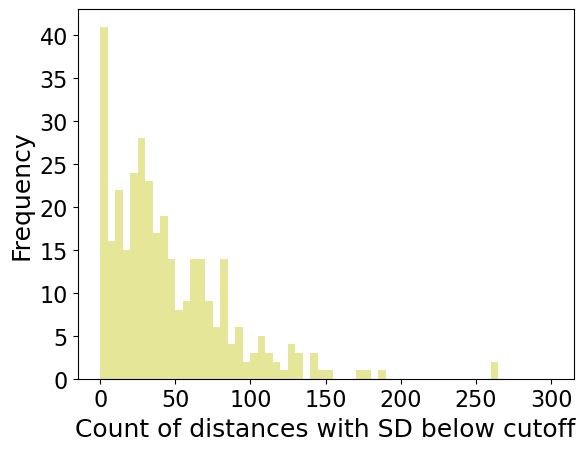

In [24]:
#Define cutoff relative to 2 away
average_2_away_max_sd = np.average(sd_2a_max_list)
print("average 2 away. max sd")
print(average_2_away_max_sd)

mult = 1.0
sd_threshold = average_2_away_max_sd * mult

#for each molecule how many distances have sd across conformers below cutoff?
count_further_away_sds_below_mult_max = []
for sd_further_l in all_further_sd_list:
    sd_within_cutoff = len([s for s in sd_further_l if s < sd_threshold])
    count_further_away_sds_below_mult_max.append(sd_within_cutoff)
    
#plot
print(np.linspace(0, 300, 61))
bins_pl = list(np.linspace(0, 300, 61))
plt.hist(count_further_away_sds_below_mult_max, bins = bins_pl, color = [0.9, 0.9, 0.6])
plt.xlabel(f"Count of distances with SD below cutoff", fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel("Frequency", fontsize = 18)

print("How many entries?")
print(len(count_further_away_sds_below_mult_max))
print("How many removed?")
print(len(pdb_error_list))

In [ ]:
lig

In [ ]:
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
heavy_atom_list = []
heavy_atom_bonds = []

#Record all heavy atoms
for a in lig.GetAtoms():
    if a.GetAtomicNum() > 1:
        print(f"found atom {a.GetSymbol()}")
        heavy_atom_list.append(a.GetIdx())
    else:
        print("found H")

#Find each bond, record
for b in lig.GetBonds():
    at1 = b.GetBeginAtomIdx()
    at2 = b.GetEndAtomIdx()
    at1_an = lig.GetAtomWithIdx(at1).GetAtomicNum()
    at2_an = lig.GetAtomWithIdx(at2).GetAtomicNum()
    if at1_an == 1 or at2_an == 1:
        continue
    else:
        print("heavy atom bond")
        print(f"{at1} element {at1_an}")
        print(f"{at2} element {at2_an}")
        print("----")
        heavy_atom_bonds.append([at1, at2])
    #print([x.GetAtomicNum() for x in at.GetNeighbors()])

In [ ]:
#keys- atoms, values- neighbors 1 and 2 away
atom_neighbor_dict_12_away = {}
atom_neighbor_dict_1_away = {}
atom_neighbor_dict_2_away = {}

#Initialize and 1st shell neighbors
for a in heavy_atom_list:
    atom_neighbor_dict_1_away[a] = []
    
    #Add all 1 away
    for b in heavy_atom_bonds:
        print(b)
        if b[0] == a:
            atom_neighbor_dict_1_away[a].append(b[1])
        if b[1] == a:
            atom_neighbor_dict_1_away[a].append(b[0])
print("1 away")
print(atom_neighbor_dict)

#2 away neighbors
for a2 in heavy_atom_list:
    atom_neighbor_dict_2_away[a2] = []
    
    #Now add in the neighbor's neighbors
    #All 1 away from the neighbor
    #Filter for a2 though
    for b2 in heavy_atom_bonds:
        #print(b2)
        if b2[0] == a2:
            neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[1]] if i is not a2]
            atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2
        if b2[1] == a2:
            neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[0]] if i is not a2]
            atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2

print("2 away")
print(atom_neighbor_dict_2_away)

#Combine 1 and 2 away
for a12 in heavy_atom_list:
    atom_neighbor_dict_12_away[a12] = list(set(atom_neighbor_dict_1_away[a12] + atom_neighbor_dict_2_away[a12]))
    
print("1 and 2 away")
print(atom_neighbor_dict_12_away)

In [ ]:
away_1_dists = []
away_1_dist_dict = {}

#keys atom pairs
#values distance list- one distance/conformer
for a1add in atom_neighbor_dict_1_away.keys():
    for a1addpair in atom_neighbor_dict_1_away[a1add]:
        away_1_dist_dict[tuple(sorted([a1add, a1addpair]))] = []
        
#print(away_1_dist_dict)

#Iterate over conformers
for conf in conformers:
    #for each conformer refresh so do not duplicate e.g. (1,2) and then (2,1)
    already_checked = []
    print("new conf")
    
    #Each heavy atom
    for away1 in atom_neighbor_dict_1_away.keys():
        
        #Each heavy atom partner of interest
        for away1pair in atom_neighbor_dict_1_away[away1]:
            
            #Make sure not already found
            if sorted([away1, away1pair]) not in already_checked:
                already_checked.append([away1, away1pair])
                
                #Coordinate find, distance find
                print(f"{away1} {away1pair}")
                away1coords = conf[away1]
                away2coords = conf[away1pair]
                #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
                dist = np.linalg.norm(away1coords - away2coords)
                
                #Add to list and dictionary
                away_1_dists.append(dist)
                print(away_1_dist_dict[tuple(sorted([away1, away1pair]))])
                key_update = tuple(sorted([away1, away1pair]))
                away_1_dist_dict[key_update].append(dist)

avg_list = []
sd_list = []
for paircalc in away_1_dist_dict.keys():
    dist_analyze = away_1_dist_dict[paircalc]
    avg_list.append(np.average(dist_analyze))
    sd_list.append(np.std(dist_analyze, ddof = 1))
    
plt.hist(sd_list)
plt.show()
plt.cla()
plt.clf()
plt.hist(avg_list)
plt.show()
plt.cla()
plt.clf()
plt.scatter(avg_list, sd_list)
plt.show()
plt.cla()
plt.clf()

In [ ]:
num_conf = 10
#Copied from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
ps = AllChem.ETKDGv2()
ids = rdDistGeom.EmbedMultipleConfs(lig, num_conf, ps)
AllChem.MMFFOptimizeMoleculeConfs(lig)
conformers = []
for i in range(num_conf):
    conformers.append(lig.GetConformer(i).GetPositions())
print(conformers[0])
print(len(conformers))

In [ ]:
#ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
param = rdDistGeom.ETKDGv2()
#param.pruneRmsThresh = prunermsthresh
cids = rdDistGeom.EmbedMultipleConfs(lig, 20, param)
mp = AllChem.MMFFGetMoleculeProperties(lig, mmffVariant='MMFF94s')
AllChem.MMFFOptimizeMoleculeConfs(lig, numThreads=0, mmffVariant='MMFF94s')

In [ ]:
cids[1]

In [ ]:
#Ref https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py copied
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html copied
for i in range(20):
    #mol_rdkit = copy.deepcopy(lig)

    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit = AllChem.AddHs(mol_rdkit)
    #generate_conformer(mol_rdkit)
    #if remove_hs:
    #    mol_rdkit = RemoveHs(mol_rdkit, sanitize=True)
    #mol = copy.deepcopy(mol_maybe_noh)
    #if rotable_bonds:
    #    optimize_rotatable_bonds(mol_rdkit, mol, rotable_bonds, popsize=popsize, maxiter=maxiter)
    #mol.AddConformer(mol_rdkit.GetConformer())
    #rms_list = []
    #AllChem.AlignMolConformers(mol, RMSlist=rms_list)
    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit.AddConformer(lig.GetConformers()[i])
    print(lig.GetConformers()[i].GetPositions())
    print("--------")

In [ ]:
np.linspace(0,2,11)